In [2]:
!pip install librosa

   ---------------------------------------- 0.0/2.7 MB ? eta -:--:--
   ---------------------------------------- 0.0/2.7 MB ? eta -:--:--
   ---------------------------------------- 0.0/2.7 MB ? eta -:--:--
   --- ------------------------------------ 0.3/2.7 MB ? eta -:--:--
   --- ------------------------------------ 0.3/2.7 MB ? eta -:--:--
   ------- -------------------------------- 0.5/2.7 MB 541.6 kB/s eta 0:00:05
   --------------- ------------------------ 1.0/2.7 MB 988.0 kB/s eta 0:00:02
   ----------------------- ---------------- 1.6/2.7 MB 1.3 MB/s eta 0:00:01
   ---------------------------------- ----- 2.4/2.7 MB 1.7 MB/s eta 0:00:01
   ---------------------------------------- 2.7/2.7 MB 1.8 MB/s eta 0:00:00
   ---------------------------------------- 0.0/1.0 MB ? eta -:--:--
   ------------------------------- -------- 0.8/1.0 MB 4.2 MB/s eta 0:00:01
   ---------------------------------------- 1.0/1.0 MB 3.4 MB/s eta 0:00:00
   ---------------------------------------- 0.0/28

In [3]:
!pip install soundfile

In [ ]:
#requirements
import librosa
import numpy as np
import soundfile as sf
import os
import random
import librosa.display
import matplotlib.pyplot as plt
import json
from sklearn.model_selection import train_test_split
import tensorflow.keras as keras
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.metrics import classification_report

# add noise

In [77]:
def load_background_noises(noise_folder):
    noise_files = []
    for file in os.listdir(noise_folder):
        if file.endswith('.wav'):
            noise, sr = librosa.load(os.path.join(noise_folder, file), sr=16000)
            noise_files.append(noise)
    return noise_files

def add_background_noise(audio, background_noises, noise_level=0.1):
    noise = random.choice(background_noises)
    sample_length = len(audio)
    if len(noise) > sample_length:
        start = random.randint(0, len(noise) - sample_length)
        noise_segment = noise[start:start + sample_length]
    else:
        noise_segment = np.pad(noise, (0, max(0, sample_length - len(noise))), 'constant')
    
    augmented_audio = audio + noise_level * noise_segment
    return augmented_audio

def augment_and_save(input_folder, background_noises, output_folder_base, noise_level=0.1):
    
    for command in os.listdir(input_folder):
        command_folder = os.path.join(input_folder, command)
        
        if not os.path.isdir(command_folder):
            continue  
        
        
        output_folder = os.path.join(output_folder_base, f"{command}_with_noise")
        os.makedirs(output_folder, exist_ok=True)
        
        
        for i, file_name in enumerate(os.listdir(command_folder)):
            if file_name.endswith('.wav'):
                file_path = os.path.join(command_folder, file_name)
                
                
                audio, sr = librosa.load(file_path, sr=16000)
                
               
                augmented_audio = add_background_noise(audio, background_noises, noise_level)
                
                
                output_path = os.path.join(output_folder, f"{command}_with_noise_{i}.wav")
                sf.write(output_path, augmented_audio, samplerate=16000)


noise_folder_path = r'C:/Users/LENOVO/Downloads/tensorflow-speech-recognition-challenge/train/_background_noise_'
audio_input_folder = r'C:/Users/LENOVO/Downloads/tensorflow-speech-recognition-challenge/train/audio'
audio_with_noise_folder = r'C:/Users/LENOVO/Downloads/tensorflow-speech-recognition-challenge/train/audio_with_noise'


background_noises = load_background_noises(noise_folder_path)


augment_and_save(audio_input_folder, background_noises, audio_with_noise_folder, noise_level=0.1)


# Preprocessing

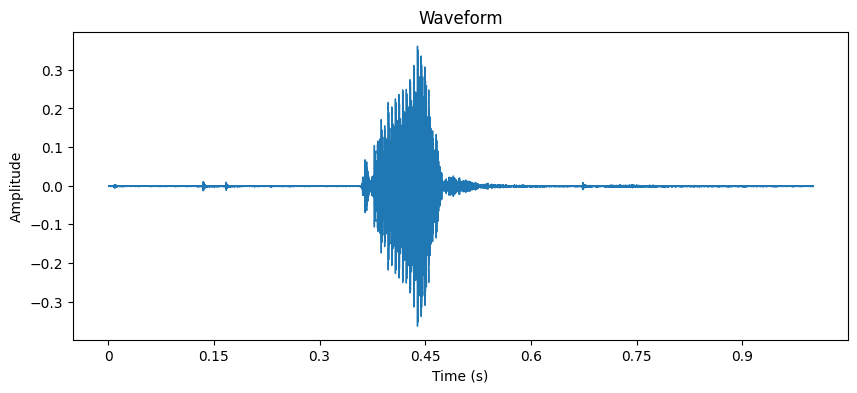

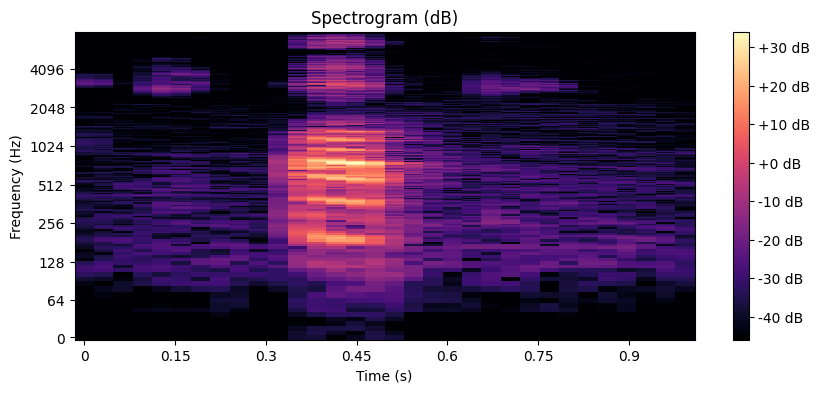

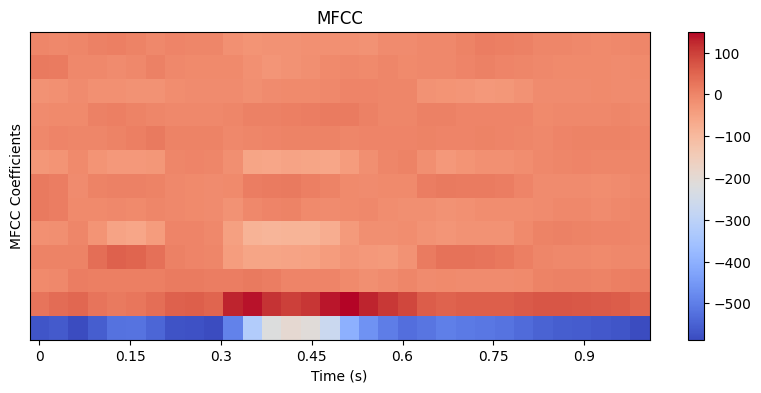

In [9]:
def plot_waveform(file_path):
    audio, sr = librosa.load(file_path, sr=16000)  
    plt.figure(figsize=(10, 4))
    librosa.display.waveshow(audio, sr=sr)
    plt.title("Waveform")
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")
    plt.show()
    
def plot_spectrogram(file_path):
    audio, sr = librosa.load(file_path, sr=16000)
    S = librosa.stft(audio)
    S_dB = librosa.amplitude_to_db(abs(S))
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(S_dB, sr=sr, x_axis='time', y_axis='log')
    plt.colorbar(format='%+2.0f dB')
    plt.title("Spectrogram (dB)")
    plt.xlabel("Time (s)")
    plt.ylabel("Frequency (Hz)")
    plt.show()
    
def plot_mfcc(file_path):
    audio, sr = librosa.load(file_path, sr=16000)
    mfccs = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=13)  # Use 13 MFCCs, a common setting
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(mfccs, sr=sr, x_axis='time')
    plt.colorbar()
    plt.title("MFCC")
    plt.xlabel("Time (s)")
    plt.ylabel("MFCC Coefficients")
    plt.show()


file_path = r'C:/Users/LENOVO/Downloads/tensorflow-speech-recognition-challenge/train/audio/up/0a7c2a8d_nohash_0.wav'
plot_waveform(file_path)
plot_spectrogram(file_path)
plot_mfcc(file_path)


In [1]:

input_folder = r'C:\Users\LENOVO\Downloads\tensorflow-speech-recognition-challenge\train\audio_mixt'
json_path = "data_mixt.json"


data = {
    "name": [],
    "mfccs": [],
    "labels": []
}

def extract_mfcc(input_folder, sr=16000, n_mfcc=13, win_length=30, hop_length=10, max_length=98):
    commands = os.listdir(input_folder)  
    total_files = 0  

    for index, command in enumerate(commands):  
        command_folder = os.path.join(input_folder, command)
        
        if not os.path.isdir(command_folder):
            continue  

        files = [f for f in os.listdir(command_folder) if f.endswith('.wav')]  
        num_files = len(files)  
        total_files += num_files  
        print(f"Command: {command}, Files: {num_files}")  

        for file_name in files:
            file_path = os.path.join(command_folder, file_name)
            audio, sr = librosa.load(file_path, sr=sr)
            
           
            mfccs = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=n_mfcc, 
                                          n_fft=int(sr * (win_length / 1000)), 
                                          hop_length=int(sr * (hop_length / 1000)))

            # Normalize MFCCs using z-score
            mfcc_mean = np.mean(mfccs, axis=1, keepdims=True)
            mfcc_std = np.std(mfccs, axis=1, keepdims=True)
            mfccs = (mfccs - mfcc_mean) / (mfcc_std + 1e-10)  

            
            mfccs = mfccs.T  

            if mfccs.shape[0] < max_length:
                
                mfccs = np.pad(mfccs, ((0, max_length - mfccs.shape[0]), (0, 0)), mode='constant')
            else:
                
                mfccs = mfccs[:max_length, :]
                
            
            data["name"].append(file_name)
            data["mfccs"].append(mfccs.tolist())  
            data["labels"].append(index) 

    
    with open(json_path, 'w') as json_file:
        json.dump(data, json_file)

    print(f"Data saved to {json_path}")
    print(f"Total .wav files processed: {total_files}") 


extract_mfcc(input_folder, sr=16000, n_mfcc=13, win_length=30, hop_length=10, max_length=98)


Command: down, Files: 5901
Command: go, Files: 5901
Command: left, Files: 5901
Command: noise, Files: 5901
Command: right, Files: 5901
Command: stop, Files: 5901
Command: up, Files: 5901
Data saved to data_mixt.json
Total .wav files processed: 41307


In [1]:
dataset_path=r"C:\Users\LENOVO\data_mixt.json"

In [2]:
def load_data(dataset_path):
   
    with open(dataset_path, "r") as fp:
        data = json.load(fp)
   
    X = np.array(data["mfccs"])
    y = np.array(data["labels"])
    return X, y

In [3]:
def prepare_data(test_size,validation_size):
    x,y = load_data(dataset_path)
    x_train,x_test,y_train,y_test = train_test_split(x,y,test_size = test_size, shuffle=True)
    x_train,x_validation,y_train,y_validation = train_test_split(x_train, y_train, test_size = validation_size, shuffle=True)

    return x_train, x_validation, x_test, y_train, y_validation, y_test

In [4]:
x,y = load_data(dataset_path)

In [5]:
x.shape

(41307, 98, 13)

In [6]:
x_train, x_validation, x_test, y_train, y_validation, y_test = prepare_data(0.15,0.15)

In [7]:
x_train.shape

(29843, 98, 13)

In [8]:
x_test.shape

(6197, 98, 13)

In [9]:
x_validation.shape

(5267, 98, 13)

# 3rd model:0 experience

In [10]:
def build_model00():
    model = models.Sequential([
        
        layers.Input(shape=(98, 13, 1)),

        
        layers.Conv2D(8, kernel_size=(3, 3), strides=(1, 1), padding='same'),
        layers.Activation('relu'),

        
        layers.Conv2D(8, kernel_size=(3, 3), strides=(1, 1), padding='same'),
        layers.Activation('relu'),

        
        layers.Flatten(),

       
        layers.Dense(16, activation='relu'),

        
        layers.Dense(7, activation='softmax')
    ])

   
    model.compile(optimizer='SGD', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model


In [11]:
model00 = build_model00()
model00.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 98, 13, 8)      │            80 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 98, 13, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 98, 13, 8)      │           584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 98, 13, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 10192)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 16)             │       163,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 7)              │           119 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 163,871 (640.12 KB)

 Trainable params: 163,871 (640.12 KB)

 Non-trainable params: 0 (0.00 B)

In [12]:
history=model00.fit(x_train, y_train, validation_data=(x_validation, y_validation), batch_size=32, epochs=20)

Epoch 1/20
933/933 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.4161 - loss: 1.5379 - val_accuracy: 0.7277 - val_loss: 0.8067
Epoch 2/20
933/933 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - accuracy: 0.7763 - loss: 0.6627 - val_accuracy: 0.8027 - val_loss: 0.6032
Epoch 3/20
933/933 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - accuracy: 0.8427 - loss: 0.4747 - val_accuracy: 0.8191 - val_loss: 0.5551
Epoch 4/20
933/933 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - accuracy: 0.8793 - loss: 0.3634 - val_accuracy: 0.8356 - val_loss: 0.5080
Epoch 5/20
933/933 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - accuracy: 0.9040 - loss: 0.2929 - val_accuracy: 0.8365 - val_loss: 0.5128
Epoch 6/20
933/933 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - accuracy: 0.9238 - loss: 0.2381 - val_accuracy: 0.8417 - val_loss: 0.5240
Epoch 7/20
933/933 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - accuracy: 0.9419 - loss: 0.1825 - val_accuracy: 0.8439 - val_loss: 0.5241
Epoch 8/20
933/933 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - accuracy: 0.9546 - loss: 0.1426 - val_accuracy: 

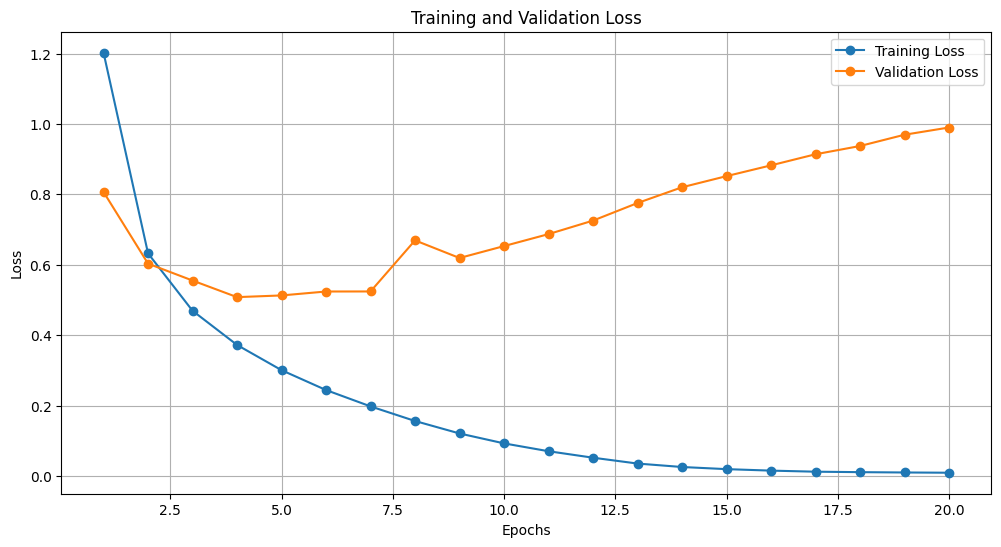

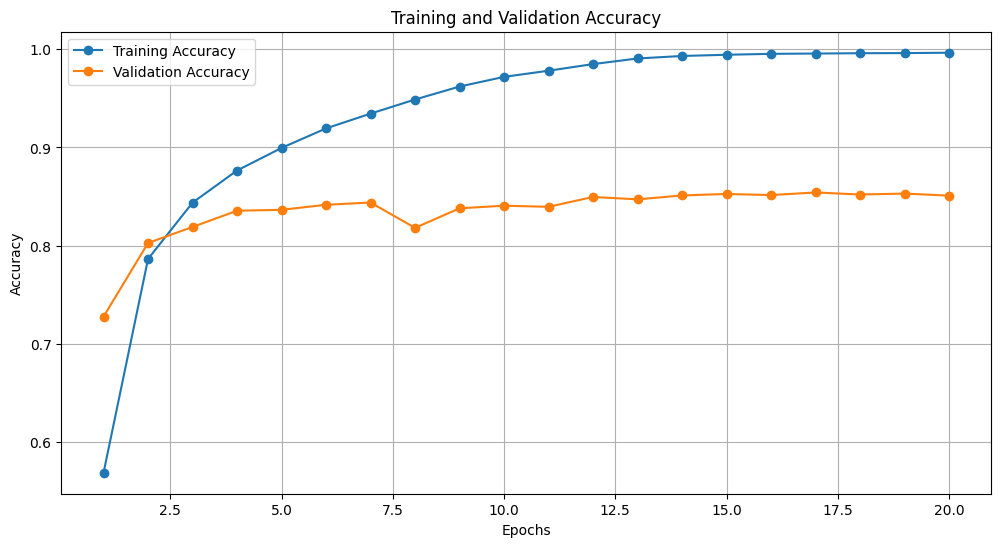

In [13]:
def vis_loss_accu(history):
    
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    train_accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']
    epochs = range(1, len(train_loss) + 1)

    
    plt.figure(figsize=(12, 6))
    plt.plot(epochs, train_loss, label='Training Loss', marker='o')
    plt.plot(epochs, val_loss, label='Validation Loss', marker='o')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()
    plt.show()

    
    plt.figure(figsize=(12, 6))
    plt.plot(epochs, train_accuracy, label='Training Accuracy', marker='o')
    plt.plot(epochs, val_accuracy, label='Validation Accuracy', marker='o')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid()
    plt.show()


vis_loss_accu(history)

In [15]:
test_loss, test_accuracy = model00.evaluate(x_test, y_test)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

194/194 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8483 - loss: 0.9767
Test Loss: 0.9426824450492859
Test Accuracy: 0.8489591479301453


# 3rd model:1st experience

In [20]:
def build_model3_1():
    model = models.Sequential([
        
        layers.Input(shape=(98, 13, 1)),

        
        layers.Conv2D(16, kernel_size=(3, 3), strides=(1, 1), padding='same'),
        layers.Activation('relu'),
        layers.MaxPooling2D(pool_size=(2, 2)),

        
        layers.Conv2D(32, kernel_size=(3, 3), strides=(1, 1), padding='same'),
        layers.Activation('relu'),
        layers.MaxPooling2D(pool_size=(2, 2)),

       
        layers.Flatten(),

       
        layers.Dense(64, activation='relu'),
        

        
        layers.Dense(7, activation='softmax')
    ])

    
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model


In [21]:
model3_1 = build_model3_1()
model3_1.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 98, 13, 16)     │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 98, 13, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 49, 6, 16)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 49, 6, 32)      │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 49, 6, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 24, 3, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 2304)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │       147,520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 7)              │           455 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 152,775 (596.78 KB)

 Trainable params: 152,775 (596.78 KB)

 Non-trainable params: 0 (0.00 B)

In [22]:
history=model3_1.fit(x_train, y_train, validation_data=(x_validation, y_validation), batch_size=32, epochs=20)

Epoch 1/20
933/933 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - accuracy: 0.5516 - loss: 1.2039 - val_accuracy: 0.8356 - val_loss: 0.5030
Epoch 2/20
933/933 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - accuracy: 0.8704 - loss: 0.3960 - val_accuracy: 0.8878 - val_loss: 0.3468
Epoch 3/20
933/933 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - accuracy: 0.9201 - loss: 0.2507 - val_accuracy: 0.8880 - val_loss: 0.3579
Epoch 4/20
933/933 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - accuracy: 0.9391 - loss: 0.1850 - val_accuracy: 0.8925 - val_loss: 0.3655
Epoch 5/20
933/933 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - accuracy: 0.9547 - loss: 0.1326 - val_accuracy: 0.8982 - val_loss: 0.3564
Epoch 6/20
933/933 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - accuracy: 0.9712 - loss: 0.0910 - val_accuracy: 0.8960 - val_loss: 0.3918
Epoch 7/20
933/933 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - accuracy: 0.9773 - loss: 0.0661 - val_accuracy: 0.8884 - val_loss: 0.4383
Epoch 8/20
933/933 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - accuracy: 0.9823 - loss: 0.0550 - val_accuracy: 

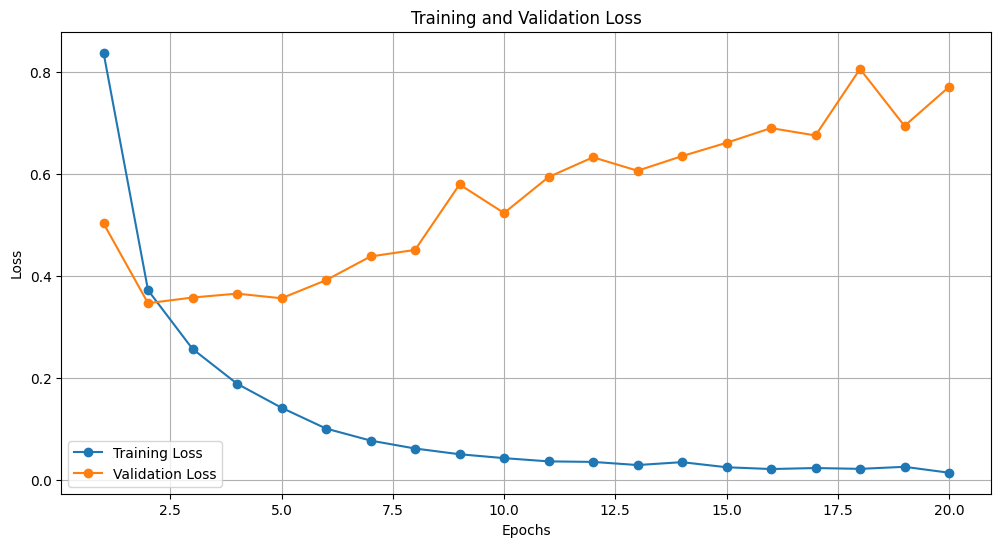

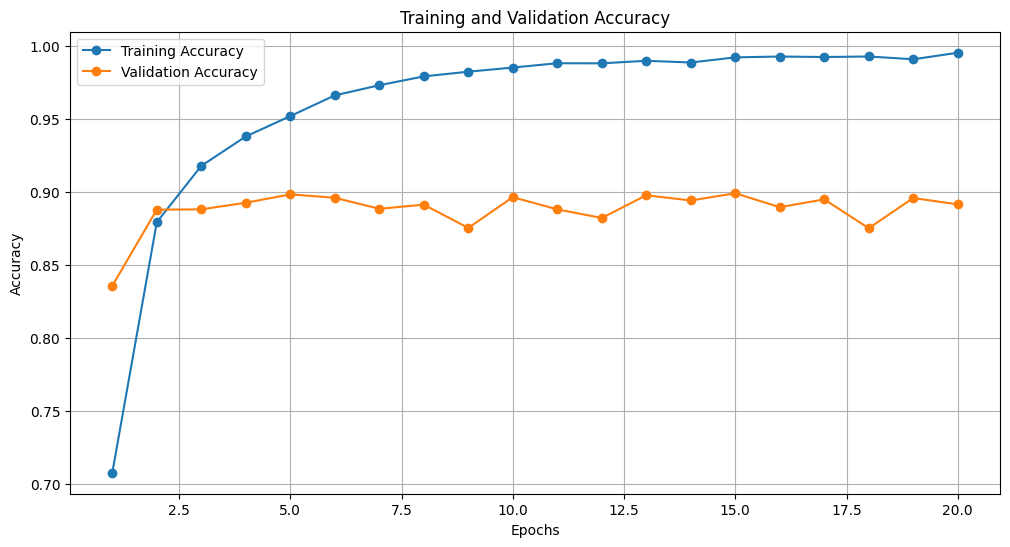

In [23]:
vis_loss_accu(history)

In [24]:
test_loss, test_accuracy = model3_1.evaluate(x_test, y_test)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

194/194 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8994 - loss: 0.6994
Test Loss: 0.6966599225997925
Test Accuracy: 0.895271897315979


# 3rd model:2st experience

In [58]:
def build_model3_2():
    model = models.Sequential([
        
        layers.Input(shape=(98, 13, 1)),
        layers.Conv2D(filters=16, kernel_size=(4, 4), padding='valid'),
        layers.Activation('relu'),
        
        
        layers.Conv2D(filters=32, kernel_size=(4, 4), padding='valid'),
        layers.Activation('relu'),
        layers.MaxPooling2D(2, 2),
        
        
        layers.Conv2D(filters=64, kernel_size=(2, 2), padding='same'),
        layers.Activation('relu'),
        layers.MaxPooling2D(2, 2),
        
        
        layers.Conv2D(filters=128, kernel_size=(2, 2), padding='same'),
        layers.Activation('relu'),
        
        
        layers.Flatten(),
        layers.Dense(256, activation='relu'),
       
        
        layers.Dense(128, activation='relu'),
        
        
        layers.Dense(7, activation='softmax') 
    ])

    
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

In [59]:
model3_2 = build_model3_2()
model3_2.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_18 (Conv2D)              │ (None, 95, 10, 16)     │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (None, 92, 7, 32)      │         8,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 46, 3, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_20 (Conv2D)              │ (None, 46, 3, 64)      │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 23, 1, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_21 (Conv2D)              │ (None, 23, 1, 128)     │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 2944)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 256)            │       753,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 7)              │           903 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 837,367 (3.19 MB)

 Trainable params: 837,367 (3.19 MB)

 Non-trainable params: 0 (0.00 B)

In [60]:
history=model3_2.fit(x_train, y_train, validation_data=(x_validation, y_validation), batch_size=32, epochs=20)

Epoch 1/20
933/933 ━━━━━━━━━━━━━━━━━━━━ 35s 34ms/step - accuracy: 0.5804 - loss: 1.0949 - val_accuracy: 0.8975 - val_loss: 0.3125
Epoch 2/20
933/933 ━━━━━━━━━━━━━━━━━━━━ 30s 32ms/step - accuracy: 0.9112 - loss: 0.2714 - val_accuracy: 0.9163 - val_loss: 0.2608
Epoch 3/20
933/933 ━━━━━━━━━━━━━━━━━━━━ 31s 33ms/step - accuracy: 0.9403 - loss: 0.1883 - val_accuracy: 0.9180 - val_loss: 0.2655
Epoch 4/20
933/933 ━━━━━━━━━━━━━━━━━━━━ 31s 33ms/step - accuracy: 0.9540 - loss: 0.1389 - val_accuracy: 0.9307 - val_loss: 0.2220
Epoch 5/20
933/933 ━━━━━━━━━━━━━━━━━━━━ 30s 32ms/step - accuracy: 0.9662 - loss: 0.1025 - val_accuracy: 0.9275 - val_loss: 0.2569
Epoch 6/20
933/933 ━━━━━━━━━━━━━━━━━━━━ 32s 34ms/step - accuracy: 0.9709 - loss: 0.0862 - val_accuracy: 0.9343 - val_loss: 0.2491
Epoch 7/20
933/933 ━━━━━━━━━━━━━━━━━━━━ 31s 33ms/step - accuracy: 0.9785 - loss: 0.0665 - val_accuracy: 0.9337 - val_loss: 0.2551
Epoch 8/20
933/933 ━━━━━━━━━━━━━━━━━━━━ 32s 35ms/step - accuracy: 0.9829 - loss: 0.0554 - 

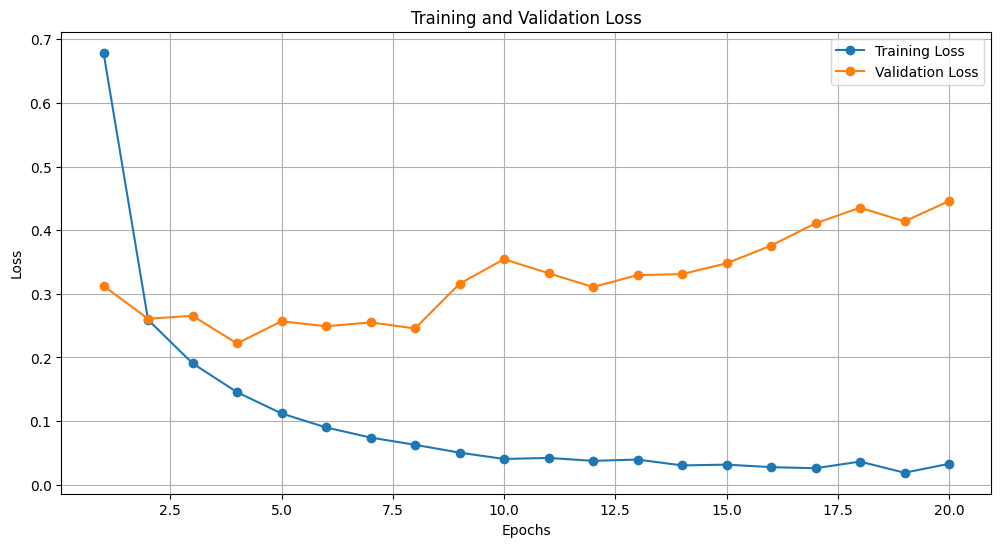

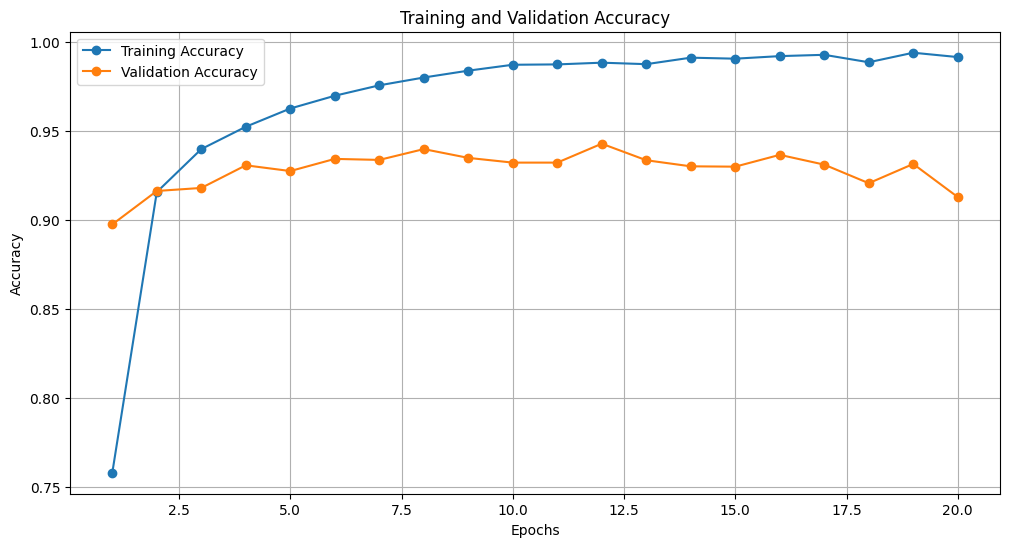

In [61]:
vis_loss_accu(history)

In [62]:
test_loss, test_accuracy = model3_2.evaluate(x_test, y_test)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

194/194 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.9184 - loss: 0.4229
Test Loss: 0.43794143199920654
Test Accuracy: 0.9138292670249939


# 3rd model:3st experience

In [38]:
def build_model3_3():
    model = models.Sequential([
        
        layers.Input(shape=(98, 13, 1)),  

        
        layers.Conv2D(64, (10, 4), strides=(1, 1), padding='valid'),
        layers.BatchNormalization(),  
        layers.Activation('relu'),  
        layers.MaxPooling2D(pool_size=(2, 2)),  
        layers.Dropout(0.5), 

        
        layers.Conv2D(128, (5, 2), strides=(1, 1), padding='valid'),
        layers.BatchNormalization(),  
        layers.Activation('relu'), 
        layers.MaxPooling2D(pool_size=(2, 2)),  
        layers.Dropout(0.5),  

        
        layers.Flatten(),

        
        layers.Dense(64),
        layers.BatchNormalization(), 
        layers.Activation('relu'),

        
        layers.Dense(128),
        layers.BatchNormalization(),  
        layers.Activation('relu'),

        
        layers.Dense(7, activation='softmax')  
    ])

   
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model


In [39]:
model3_3 = build_model3_3()
model3_3.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_12 (Conv2D)              │ (None, 89, 10, 64)     │         2,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 89, 10, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 89, 10, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 44, 5, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 44, 5, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 40, 4, 128)     │        82,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 40, 4, 128)     │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_5 (Activation)       │ (None, 40, 4, 128)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 20, 2, 128)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 20, 2, 128)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 5120)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 64)             │       327,744 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_6 (Activation)       │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_7 (Activation)       │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 7)              │           903 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 423,175 (1.61 MB)

 Trainable params: 422,407 (1.61 MB)

 Non-trainable params: 768 (3.00 KB)

In [40]:
history=model3_3.fit(x_train, y_train, validation_data=(x_validation, y_validation), batch_size=32, epochs=20)

Epoch 1/20
933/933 ━━━━━━━━━━━━━━━━━━━━ 79s 80ms/step - accuracy: 0.5142 - loss: 1.3211 - val_accuracy: 0.8219 - val_loss: 0.5080
Epoch 2/20
933/933 ━━━━━━━━━━━━━━━━━━━━ 71s 76ms/step - accuracy: 0.8182 - loss: 0.5411 - val_accuracy: 0.8982 - val_loss: 0.3154
Epoch 3/20
933/933 ━━━━━━━━━━━━━━━━━━━━ 71s 77ms/step - accuracy: 0.8574 - loss: 0.4202 - val_accuracy: 0.9032 - val_loss: 0.3062
Epoch 4/20
933/933 ━━━━━━━━━━━━━━━━━━━━ 71s 76ms/step - accuracy: 0.8788 - loss: 0.3594 - val_accuracy: 0.9231 - val_loss: 0.2409
Epoch 5/20
933/933 ━━━━━━━━━━━━━━━━━━━━ 71s 76ms/step - accuracy: 0.8950 - loss: 0.3146 - val_accuracy: 0.9263 - val_loss: 0.2314
Epoch 6/20
933/933 ━━━━━━━━━━━━━━━━━━━━ 71s 76ms/step - accuracy: 0.9028 - loss: 0.2851 - val_accuracy: 0.9330 - val_loss: 0.2129
Epoch 7/20
933/933 ━━━━━━━━━━━━━━━━━━━━ 72s 77ms/step - accuracy: 0.9139 - loss: 0.2648 - val_accuracy: 0.9299 - val_loss: 0.2114
Epoch 8/20
933/933 ━━━━━━━━━━━━━━━━━━━━ 73s 78ms/step - accuracy: 0.9162 - loss: 0.2521 - 

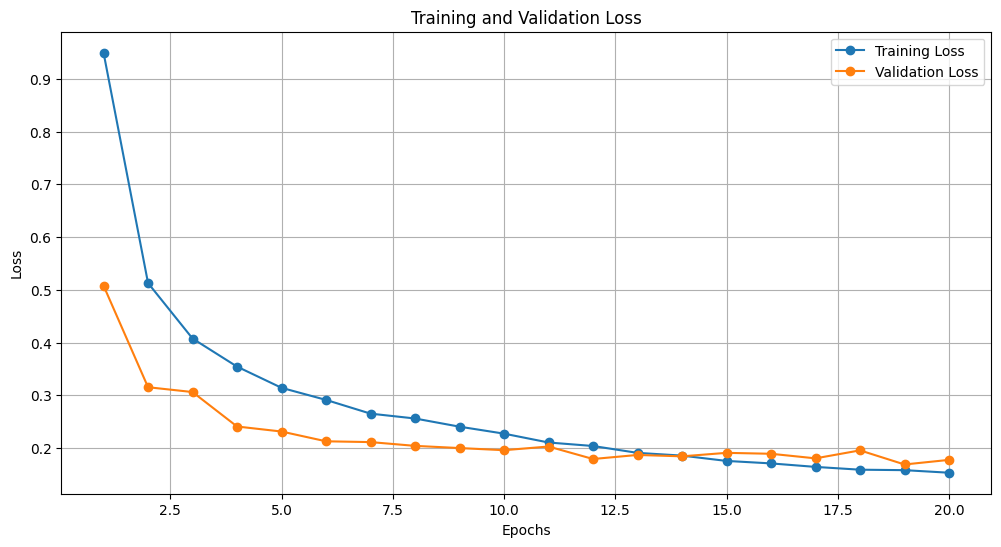

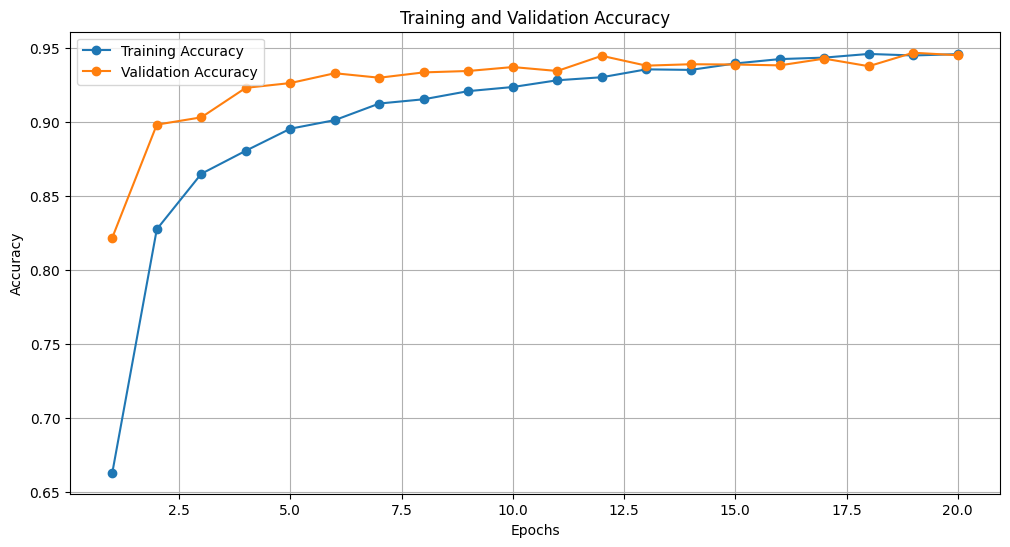

In [41]:
vis_loss_accu(history)

In [42]:
test_loss, test_accuracy = model3_3.evaluate(x_test, y_test)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

194/194 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.9445 - loss: 0.1695
Test Loss: 0.18965022265911102
Test Accuracy: 0.9393254518508911


# 3rd model

In [43]:
def build_model3():
    model = models.Sequential([
        
        layers.Input(shape=(98, 13, 1)),

       
        layers.Conv2D(32, kernel_size=(3, 3), strides=(1, 1), padding='same'),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Dropout(0.3),

        
        layers.Conv2D(64, kernel_size=(3, 3), strides=(1, 1), padding='same'),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Dropout(0.3),

       
        layers.Conv2D(128, kernel_size=(3, 3), strides=(1, 1), padding='same'),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Dropout(0.3),

       
        layers.Conv2D(256, kernel_size=(3, 3), strides=(1, 1), padding='same'),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.GlobalAveragePooling2D(),
        layers.Dropout(0.4),

       
        layers.Dense(256),
        layers.Dropout(0.4),

        layers.Dense(128),
        layers.Dropout(0.3),

        
        layers.Dense(7, activation='softmax')
    ])

    
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model


In [44]:
model3 = build_model3()
model3.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_14 (Conv2D)              │ (None, 98, 13, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 98, 13, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_8 (Activation)       │ (None, 98, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 49, 6, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 49, 6, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 49, 6, 64)      │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 49, 6, 64)      │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_9 (Activation)       │ (None, 49, 6, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 24, 3, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 24, 3, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 24, 3, 128)     │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 24, 3, 128)     │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_10 (Activation)      │ (None, 24, 3, 128)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 12, 1, 128)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 12, 1, 128)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 12, 1, 256)     │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 12, 1, 256)     │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_11 (Activation)      │ (None, 12, 1, 256)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 489,351 (1.87 MB)

 Trainable params: 488,391 (1.86 MB)

 Non-trainable params: 960 (3.75 KB)

In [45]:
history=model3.fit(x_train, y_train, validation_data=(x_validation, y_validation), batch_size=32, epochs=20)

Epoch 1/20
933/933 ━━━━━━━━━━━━━━━━━━━━ 67s 67ms/step - accuracy: 0.5491 - loss: 1.2706 - val_accuracy: 0.8971 - val_loss: 0.3063
Epoch 2/20
933/933 ━━━━━━━━━━━━━━━━━━━━ 63s 67ms/step - accuracy: 0.8633 - loss: 0.4198 - val_accuracy: 0.9136 - val_loss: 0.2495
Epoch 3/20
933/933 ━━━━━━━━━━━━━━━━━━━━ 63s 67ms/step - accuracy: 0.8894 - loss: 0.3441 - val_accuracy: 0.9303 - val_loss: 0.2127
Epoch 4/20
933/933 ━━━━━━━━━━━━━━━━━━━━ 63s 67ms/step - accuracy: 0.9082 - loss: 0.2873 - val_accuracy: 0.9402 - val_loss: 0.1835
Epoch 5/20
933/933 ━━━━━━━━━━━━━━━━━━━━ 63s 67ms/step - accuracy: 0.9117 - loss: 0.2722 - val_accuracy: 0.9455 - val_loss: 0.1663
Epoch 6/20
933/933 ━━━━━━━━━━━━━━━━━━━━ 63s 67ms/step - accuracy: 0.9181 - loss: 0.2475 - val_accuracy: 0.9485 - val_loss: 0.1621
Epoch 7/20
933/933 ━━━━━━━━━━━━━━━━━━━━ 62s 67ms/step - accuracy: 0.9274 - loss: 0.2280 - val_accuracy: 0.9531 - val_loss: 0.1556
Epoch 8/20
933/933 ━━━━━━━━━━━━━━━━━━━━ 62s 67ms/step - accuracy: 0.9320 - loss: 0.2142 - 

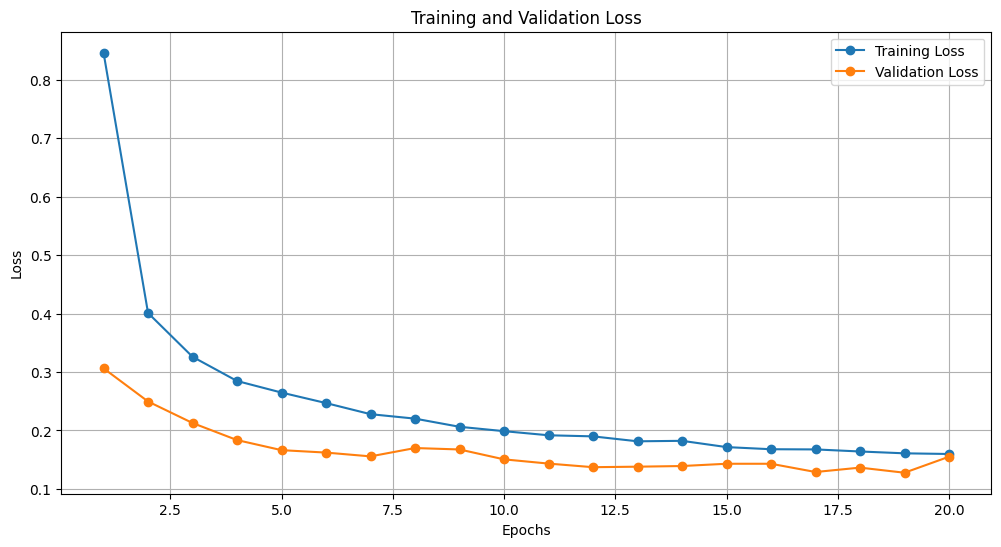

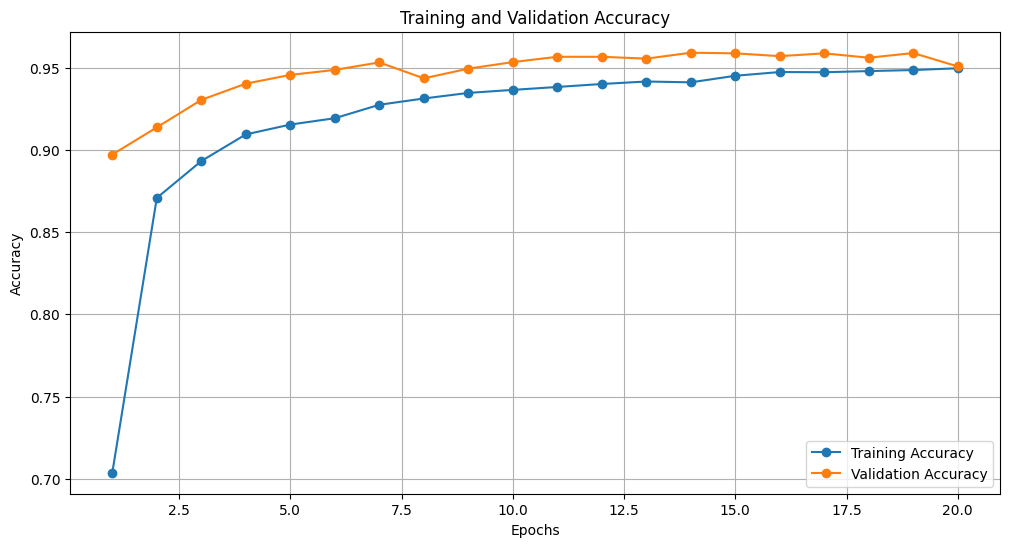

In [46]:
vis_loss_accu(history)

In [47]:
test_loss, test_accuracy = model3.evaluate(x_test, y_test)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

194/194 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - accuracy: 0.9569 - loss: 0.1338
Test Loss: 0.14372125267982483
Test Accuracy: 0.954010009765625


In [49]:
y_pred = model3.predict(x_test)

y_pred_classes = np.argmax(y_pred, axis=1)

print(classification_report(y_test, y_pred_classes))

194/194 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step
              precision    recall  f1-score   support

           0       0.93      0.97      0.95       864
           1       0.96      0.92      0.94       900
           2       0.99      0.94      0.97       888
           3       0.84      1.00      0.91       832
           4       0.99      0.96      0.98       901
           5       0.99      0.95      0.97       928
           6       0.99      0.94      0.97       884

    accuracy                           0.95      6197
   macro avg       0.96      0.95      0.95      6197
weighted avg       0.96      0.95      0.95      6197



In [50]:
model3.save("model3.keras") 
print(x_train.dtype)
print(y_train.dtype)

float64
int32


# Deployement

In [2]:
#pygame deploiement
import pygame
import numpy as np
import tensorflow as tf
import librosa
import pyaudio
import time


p = pyaudio.PyAudio()


pygame.init()


GRID_SIZE = 10
CELL_SIZE = 60
WINDOW_SIZE = GRID_SIZE * CELL_SIZE
WHITE = (255, 255, 255)
BLACK = (0, 0, 0)


model = tf.keras.models.load_model(r'C:\Users\LENOVO\model3.keras')
classes = ["down", "go", "left", "noise", "right", "stop", "up"]


screen = pygame.display.set_mode((WINDOW_SIZE, WINDOW_SIZE))
pygame.display.set_caption("Voice-Controlled Robot Labyrinth")


labyrinth = [
    [0, 1, 0, 0, 0, 0, 0, 1, 0, 0],
    [0, 1, 0, 1, 1, 1, 0, 1, 0, 0],
    [0, 0, 0, 1, 0, 0, 0, 1, 0, 1],
    [1, 1, 0, 1, 0, 1, 1, 1, 0, 1],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
    [0, 1, 1, 1, 1, 1, 1, 1, 0, 1],
    [0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
    [1, 1, 1, 1, 1, 0, 0, 1, 0, 1],
    [0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
    [0, 1, 1, 0, 1, 0, 1, 1, 1, 0]
]


robot_pos = [0, 0]
goal_pos = [9, 9]
robot_direction = "left"  


car_image = pygame.image.load(r'C:\Users\LENOVO\Pictures\Screenshots\car.png')
car_image = pygame.transform.scale(car_image, (CELL_SIZE, CELL_SIZE))

garage_image = pygame.image.load(r'C:\Users\LENOVO\Pictures\Screenshots\garage.png')
garage_image = pygame.transform.scale(garage_image, (CELL_SIZE, CELL_SIZE))


def record_audio(sr=16000):
    stream = p.open(format=pyaudio.paInt16,
                    channels=1,
                    rate=sr,
                    input=True,
                    frames_per_buffer=sr)
    
    print("Recording...")
    audio_data = stream.read(sr)  
    stream.stop_stream()
    stream.close()
    
    
    audio = np.frombuffer(audio_data, dtype=np.int16)
    print("Recording complete.")
    return audio


def preprocess_to_mfcc(audio, sr=16000, n_mfcc=13, win_length=30, hop_length=10, max_length=98):
    if audio.dtype != np.float32:
        audio = audio.astype(np.float32)

    
    mfccs = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=n_mfcc,
                                  n_fft=int(sr * (win_length / 1000)),
                                  hop_length=int(sr * (hop_length / 1000)))
    mfccs = mfccs.T  

   
    mfcc_mean = np.mean(mfccs, axis=0, keepdims=True)
    mfcc_std = np.std(mfccs, axis=0, keepdims=True)
    mfccs = (mfccs - mfcc_mean) / (mfcc_std + 1e-10)  

    
    if mfccs.shape[0] < max_length:
        mfccs = np.pad(mfccs, ((0, max_length - mfccs.shape[0]), (0, 0)), mode='constant')
    else:
        mfccs = mfccs[:max_length, :]

    return mfccs


def is_silence(audio, threshold=85):
    return np.mean(np.abs(audio)) < threshold


def predict_mic(model):
    audio = record_audio()

    
    if is_silence(audio):
        print("Silence detected.")
        return None

    
    mfcc = preprocess_to_mfcc(audio)
    mfcc = np.expand_dims(mfcc, axis=0)  
    mfcc = np.expand_dims(mfcc, axis=-1)  

    
    prediction = model.predict(mfcc, batch_size=1)  
    pred_class = np.argmax(prediction, axis=1)[0]  
    command = classes[pred_class]
    print(f"Predicted command: {command}")
    return command

def move_robot(command):
    global robot_pos, robot_direction, running
    x, y = robot_pos

    if command == "stop":
        print("Game stopped by user.")
        running = False  
    elif command in ["up", "down", "left", "right"]:
        
        robot_direction = command
    elif command == "go":
        
        if robot_direction == "up" and x > 0 and labyrinth[x - 1][y] == 0:
            robot_pos[0] -= 1
        elif robot_direction == "down" and x < GRID_SIZE - 1 and labyrinth[x + 1][y] == 0:
            robot_pos[0] += 1
        elif robot_direction == "left" and y > 0 and labyrinth[x][y - 1] == 0:
            robot_pos[1] -= 1
        elif robot_direction == "right" and y < GRID_SIZE - 1 and labyrinth[x][y + 1] == 0:
            robot_pos[1] += 1
def draw_robot():
    x, y = robot_pos
    rotated_car = car_image  
    
    if robot_direction == "up":
        rotated_car = pygame.transform.rotate(car_image, 0)  
    elif robot_direction == "down":
        rotated_car = pygame.transform.rotate(car_image, 180) 
    elif robot_direction == "left":
        rotated_car = pygame.transform.rotate(car_image, 90)  
    elif robot_direction == "right":
        rotated_car = pygame.transform.rotate(car_image, -90)  
    
    screen.blit(rotated_car, (y * CELL_SIZE, x * CELL_SIZE))


def draw_goal():
    x, y = goal_pos
    screen.blit(garage_image, (y * CELL_SIZE, x * CELL_SIZE))


running = True
while running:
    for event in pygame.event.get():
        if event.type == pygame.QUIT:
            running = False
    
    screen.fill(WHITE)

   
    for i in range(GRID_SIZE):
        for j in range(GRID_SIZE):
            color = BLACK if labyrinth[i][j] == 1 else WHITE
            pygame.draw.rect(screen, color, pygame.Rect(j * CELL_SIZE, i * CELL_SIZE, CELL_SIZE, CELL_SIZE))

   
    draw_robot()

    
    draw_goal()

    pygame.display.flip()

    
    command = predict_mic(model)
    if command:
        print(f"Command: {command}")
        move_robot(command)

    
    if robot_pos == goal_pos:
        print("You win!")
        robot_pos = [0, 0]
        robot_direction = "left"  

pygame.quit()
p.terminate()


C:\Users\LENOVO\AppData\Roaming\Python\Python312\site-packages\keras\src\saving\saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 24 variables whereas the saved optimizer has 46 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Recording...
Recording complete.
Silence detected.
Recording...
Recording complete.
Silence detected.
Recording...
Recording complete.
Silence detected.
Recording...
Recording complete.
Silence detected.
Recording...
Recording complete.
Silence detected.
Recording...
Recording complete.
Silence detected.
Recording...
Recording complete.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step
Predicted command: down
Command: down
Recording...
Recording complete.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Predicted command: go
Command: go
Recording...
Recording complete.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Predicted command: go
Command: go
Recording...
Recording complete.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Predicted command: right
Command: right
Recording...
Recording complete.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Predicted command: go
Command: go
Recording...
Recording complete.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Predicted command: go
Command: go
Recording...
Recording complete.
1/1 ━━━━━━━━━━━━━━━━

KeyboardInterrupt: 